# Stability and convergence criteria for the linear response of $N_2$

In [1]:
%autosave 0
from BigDFT import Logfiles as lf
from BigDFT import Calculators as C
from futile import Yaml
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
import sys
sys.path.insert(0,'../')
import Routine as R
outputpath = '/linear-response'

Autosave disabled


The aim of this notebook is to perform an assessment of the reliability of the results given by the linear response. 
First of all we analyze the absorption spectrum and discuss its stability in terms of both the number of virtual orbitals and the dimension of the simulation box. 
Then we try to define a set of tools for perfoming a (semi)-automatic analysis of the excitonic states of the system. We want to define a procedure that is able to state if a given excitation can be considered as "well-sampled" or not (using the given values of number of virtual states and dimension of the simulation box)

## Construction of the relevant dictionaries

We set some general parameters and perform the analysis reading the results obtained in the other notebook

In [2]:
numOrb = 5
simSetup = {
    'free-bc' : {'rmult' : [7.0,9.0,11.0], 'nVirtMax' : [303,279,232]},
    'periodic-bc' : {'rmult' :[7.0], 'nVirtMax' : [296]}
    }

In [3]:
simSetup['free-bc']['rmult']

[7.0, 9.0, 11.0]

In [4]:
statPol = {}
spectrum = {}
#excitations = {}
Data = {}
for bc,s in simSetup.iteritems():
    statPol[bc] = {}
    spectrum[bc] = {}
    #excitations[bc] = {}
    Data[bc] = {}
    
    path = bc+outputpath
    print 'path is : ', path
    %cd $path
    for ind,r in enumerate(s['rmult']):
        filename = 'log/statPol_rmult_'+str(r)+'.yaml'
        statPol[bc][r] = Yaml.load(filename)
        filename = 'log/spectrum_rmult_'+str(r)+'.yaml'
        spectrum[bc][r] = Yaml.load(filename)
        #filename = 'log/excitations_rmult_'+str(r)+'.yaml'
        #excitations[bc][r] = Yaml.load(filename)
        logpath = 'log/log-Rmult_'+str(r)+'_numVirt_'+str(s['nVirtMax'][ind])+'.yaml'
        log = !ls $logpath
        print log
        Data[bc][r] = lf.Logfile(log[0])
    %cd ../..

path is :  periodic-bc/linear-response
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/periodic-bc/linear-response
['log/log-Rmult_7.0_numVirt_296.yaml']
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2
path is :  free-bc/linear-response
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/free-bc/linear-response
['log/log-Rmult_7.0_numVirt_303.yaml']
['log/log-Rmult_9.0_numVirt_279.yaml']
['log/log-Rmult_11.0_numVirt_232.yaml']
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


In [5]:
path = 'free-bc'+outputpath
print 'path is : ', path
%cd $path
filename = 'log/spectrum_r7cut.yaml'
spectrum_r7cut = Yaml.load(filename)
%cd ../..

path is :  free-bc/linear-response
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/free-bc/linear-response
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


## Analysis of the convergence of the statical polarizability

In [6]:
statPol_ref = [10.87,10.87,15.736]

Comparison of the i-component of the statical polarizability in function of the number of virtual orbitals (or of the maximum energy) for each of the simulation setup:

bc :  periodic-bc  rmult =  7.0 emax =  [2.6672106440028158, 5.2218160404593901, 7.7144062661554527, 11.710592566463321, 13.199349917397839, 15.951539363135284, 17.763164604488804, 19.601837512350389, 20.862938164094253, 24.404509573511138]
bc :  free-bc  rmult =  9.0 emax =  [3.6716402668845434, 5.4820832514334379, 8.8989781346906742, 11.211925798428849, 13.703921739448221, 16.112665759400539, 18.154253352748867, 20.143045157365865, 21.730045603572854, 23.475958406502457]
bc :  free-bc  rmult =  11.0 emax =  [2.5817277681379442, 3.7760207420182073, 6.0968602413047037, 7.6264044434514187, 9.4368767064551413, 10.94544569640591, 12.405840281820463, 13.69708912794577, 14.195725766609879]
bc :  free-bc  rmult =  7.0 emax =  [5.6075245995729288, 8.6421718443782112, 14.441475837420493, 17.98130707653603, 21.8635160883255, 25.610339556955523, 29.281299232055698, 31.815552411348662, 34.523930354607771, 39.092177066279902]


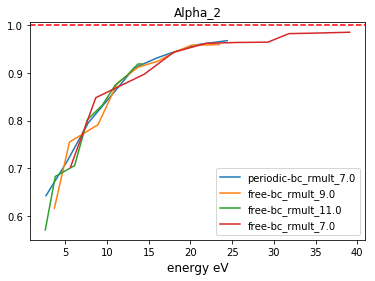

In [7]:
%matplotlib inline
alphaInd = 2
plotEnergy = True
for bc in statPol:
    for r,s in statPol[bc].iteritems():
        nalpha = s.keys()
        nalpha.sort()
        if plotEnergy:
            emax = [R.engMax(Data[bc][r],numOrb,na) for na in nalpha]
            print 'bc : ', bc, ' rmult = ', r, 'emax = ', emax
        else:
            print 'bc : ', bc, ' rmult = ', r, 'nalpha = ', nalpha
        val = [] 
        for na in nalpha:
            val.append(s[na][alphaInd])
        val = np.array(val)/statPol_ref[alphaInd]
        if plotEnergy:
            plt.plot(emax,val,label=bc+'_rmult_'+str(r))
        else:
            plt.plot(nalpha,val,label=bc+'_rmult_'+str(r))
plt.axhline(y=1.0, color='r', linestyle='--')
if plotEnergy:
    plt.xlabel('energy eV', size=12)
else:
    plt.xlabel('number of virtual orbitals', size=12)
plt.title('Alpha_'+str(alphaInd))
plt.legend()

## Stability of the  spectrum

Firstly we analyze the convergence of the spectrum in function of the number of virtual orbitals

In [8]:
bc = 'free-bc'
r = 11.0
part = 'imagPart'

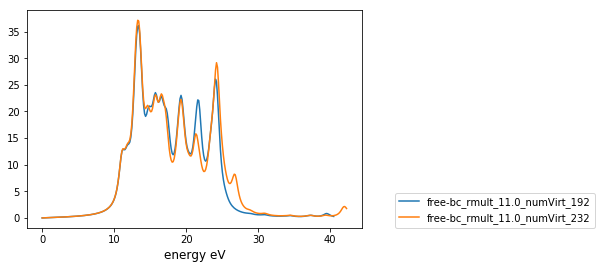

In [9]:
nVmax = simSetup[bc]['nVirtMax'][simSetup[bc]['rmult'].index(r)]
na_plot = [192,256,nVmax]
for na in na_plot:
    if na in spectrum[bc][r]:
        plt.plot(spectrum[bc][r][na]['omega'],spectrum[bc][r][na][part],label = bc+'_rmult_'+str(r)+'_numVirt_'+str(na))
plt.xlabel('energy eV', size=12)
plt.legend()
plt.legend(loc=(1.1,0))

The analysis of the plot for the two values of rmult show that:
* For rmult = 7.0 the spectrum is stable up to 40 eV
* For rmult = 9.0 the spectrum is stable up to 30 eV
* For rmult = 7.0 in the periodic-bc the spectrum is stable up to 30 eV
These results indicate that it is interesting to compare the spectrum for the two values of rmult up to 30 eV

Then we compare the spectrum with different boundary conditions

In [10]:
part = 'imagPart'

periodic-bc
free-bc


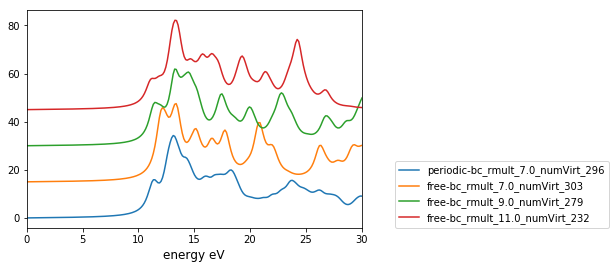

In [11]:
offs = 0.0
for bc,sim in simSetup.iteritems():
    print bc
    for r in sim['rmult']:
        na = simSetup[bc]['nVirtMax'][simSetup[bc]['rmult'].index(r)]
        plt.plot(spectrum[bc][r][na]['omega'],offs+np.array(spectrum[bc][r][na][part]),label = bc+'_rmult_'+str(r)+'_numVirt_'+str(na))
        offs+=15
plt.xlabel('energy eV', size=12)
plt.xlim(0,30)
plt.legend(loc=(1.1,0))
plt.show()

We also compare the spectrum at rmult = 7 and 9 (for the free-bc) but we cut the sum over the excitation in the r=7 spectrum to the same omegaMax obtained for r = 9.

303


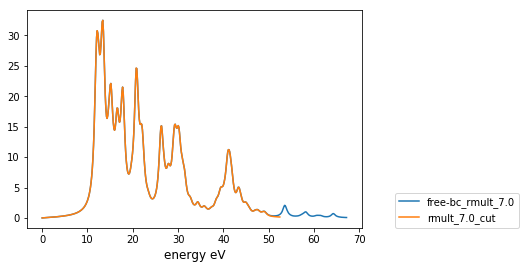

In [46]:
part = 'imagPart'
bc = 'free-bc'
r = 7.0
na = simSetup[bc]['nVirtMax'][simSetup[bc]['rmult'].index(r)]
print na
plt.plot(spectrum[bc][r][na]['omega'],np.array(spectrum[bc][r][na][part]),label = bc+'_rmult_'+str(r))
plt.plot(spectrum_r7cut['omega'],np.array(spectrum_r7cut[part]),label = 'rmult_7.0_cut')
plt.xlabel('energy eV', size=12)
#plt.xlim(0,30)
plt.legend(loc=(1.1,0))
plt.show()

We see that the cutted spectrum is equal to the uncutted one in the region below the cut. So the difference between the spectrum for different rmult cannot be ascribed to the different maximum energy of the excitation. 

## Analysis of the low energy excitations

We start by analyzing the convergence of the exctiation with respect to nalpha. This analysis is performed by checking that the dervivative of the sob is below a given treshold value. So we compute the sob and the sobStability for each case.
We set the number of virtual orbitals with negative energy equal to 2, as obtained in the free-bc simulation (the periodic code gives 3, but we use the same value for both the cases)

In [47]:
numVirtBound = 2

In [48]:
reload(R)
sob = {}
sobStability = {}
for bc,e in excitations.iteritems():
    sob[bc] = {}
    sobStability[bc] = {}
    for r,val in e.iteritems():
        sob[bc][r] = R.evalSob(numVirtBound,val)
        nalpha = val.keys()
        nalpha.sort()
        sobStability[bc][r] = R.evalSobStability(sob[bc][r],nalpha)

-0.000123210934029 0.00181686436385


(-0.00014785312083533104, 0.0021802372366150342)

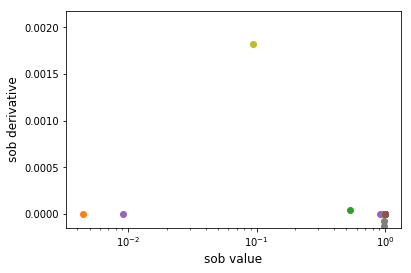

In [49]:
bc = 'free-bc'
r = 7.0
derMax = 1e-4
derMin = -1e-4
for tr,s in sobStability[bc][r].iteritems():
    der = s['derivative']
    if der > 0 and der > derMax: derMax = der
    if der < 0 and der < derMin: derMin = der
    plt.scatter(s['value'],der)

print derMin, derMax
plt.xscale('log')
plt.xlabel('sob value',size = 12)
plt.ylabel('sob derivative', size = 12)
plt.ylim(derMin*1.2,derMax*1.2)

COMMENT:
* in all the cases almost all the transition have a sob derivative close to zero.
* all the transition with s sob lower than 1e-1 are stable

Now we compare the energy of the excitations in the various setup

In [50]:
energy = {}
for bc,e in excitations.iteritems():
    energy[bc] = {}
    for r,val in e.iteritems():
        allTr = R.allTransitions(val)
        nalpha = val.keys()
        nalpha.sort()
        eng = []
        for tr in allTr:
            eng.append(val[nalpha[-1]][tr]['energy'])
        energy[bc][r] = eng

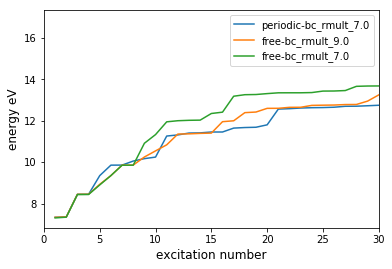

In [51]:
for bc,e in energy.iteritems():
    for r,val in e.iteritems():
        numExc = [i+1 for i in range(len(val))]
        plt.plot(numExc,val,label=bc+'_rmult_'+str(r))
plt.xlim(0,30)
plt.xlabel('excitation number',size = 12)
plt.ylabel('energy eV',size = 12)
plt.legend()

The energy of the first 4 excitation is very close in the three simulation setup, while this value raise to 8 if we compare only the setup with the free-bc. For higher excitations level the energy is setup dependent and furthermore we observe crossover among the energy levels

Now we would like to investigate the correlation between excitation with a "reliable" energy and the value of the sobStability

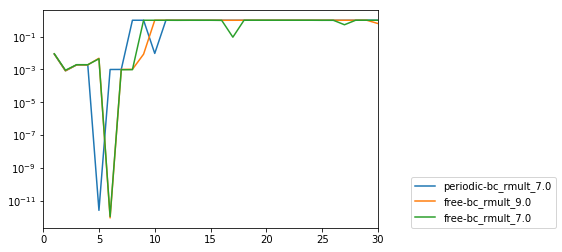

In [135]:
for bc,e in excitations.iteritems():
    for r,val in e.iteritems():
        allTr = R.allTransitions(val)
        numExc = [i+1 for i in range(len(allTr))]
        sobVal = []
        for tr in allTr:
            sobVal.append(sobStability[bc][r][tr]['value'])
        plt.plot(numExc,sobVal,label=bc+'_rmult_'+str(r))

plt.yscale('log')
plt.xlim(0,30)
plt.legend(loc=(1.1,0))

COMMENTS:
* Excitations with stable energy have a sob below 1e-2,  however if we consider also the periodic-bc case there are excitations with sob < 1e-2 that are not "stable".
* The sob seems to be an observable independent from the simulation setup: i.e. stable excitation have the same value of the sob.

QUESTIONS:
* We would like to find an indicator that is able to tell us if an excitation has been built in a reliable way in a simulation setup without using the comparison with other setup. The value of the sob seems to be a possibility but it is not completely clear (see excitation from 5 to 8 compared with the results in the free-bc cases)

Mi chiedo, se una eccitazione per la sua struttura ha bisogno di proiettarsi su stati virtuali unbounded, questa avrà mai la possibilità di convergere in una box arbitrariamente grande? Credo che più che un problema di proiettarsi sugli stati unbound sia un problema di localizzazione. Se la sob è piccola si proietta molto su stati naturalmente localizzati, e quindi non c'è problema, invece se la sob è grande la situazione è potenzialmente a rischio. Mi aspetto che per box sufficientemente grandi anche eccitazioni con sob grande possano essere ben descritte e forse bisogna capire se il sampling del continuo è in grado di localizzare oppurtnamente l'eccitazione nella box (o forse più semplicemente se la "taglia" naturale dell'eccitazione entra nella box)

Detta in altri termini: penso di sviluppare una eccitazione sugli autostati di H0 in uno spazio infinito. Ci sarà la parte bound e quella a energia positiva (continua). I coefficienti dello sviluppo saranno rilevanti per alcuni pacchetti dfi energie e questo è una proprietà fisica dell'eccitazione. Ora se penso di realizzare questo sviluppo in una box, per essere sicuro che la costruzione dell'eccitazione (in una regione opportuna e non troppo vicina ai bordi della box, credo nella regione di rho0) non sia alterata dalla box che devo fare? Non ha senso andare a vedere che l'effetto della box sugli autostati di H0 rilevanti per lo sviluppo non si vede nella regione interessante? (argomento di plausibilità) 

Per capire se questa cosa che ho scritto è sensata posso guardare i weightAlpha nei vari setup in funzione dell'energia e vedere che i picchi che appaiono siano sempre gli stessi. Questo mi indicherebbe che ci sono delle energie (o forse meglio dei pacchetti di energie) fisicamente rilevanti per quella eccitazione.

In [56]:
for bc,e in excitations.iteritems():
    for r,val in e.iteritems():
        print bc, r
        allTr = R.allTransitions(val)
        print allTr[0:14]

periodic-bc 7.0
['3,4to1,2-0', '5to1-0+5to2-0', '3,4to1,2-1', '3,4to1,2-2', '3,4to1,2-3+3,4to1,2-4', '3,4to1,2-5', '3,4to1,2-6', '5to3-0', '5to3-1', '2to1-0+2to2-0', '5to5-0', '5to5-1', '4,5to3,7-0+3,5to3,6-0', '4,5to3,7-1+3,5to3,6-1']
free-bc 9.0
['3,4to1,2-0', '5to1-0+5to2-0', '3,4to1,2-1', '3,4to1,2-2', '5to1-1+5to2-1', '3,4to1,2-3+3,4to1,2-4', '3,4to1,2-5', '3,4to1,2-6', '2to1-0+2to2-0', '5to3-0', '5to3-1', '5to4-0', '5to4-1', '5to6-0+5to5-0']
free-bc 7.0
['3,4to1,2-0', '5to1-0+5to2-0', '3,4to1,2-1', '3,4to1,2-2', '5to1-1+5to2-1', '3,4to1,2-3+3,4to1,2-4', '3,4to1,2-5', '3,4to1,2-6', '5to3-0', '5to3-1', '5to4-0', '5to4-1', '5to6-0+5to5-0', '5to6-1+5to5-1']


Il test forse è reso poco sensato della difficoltà o impossibilità in molti casi di "individuare" la stessa eccitazione nei vari setup...forse converrebbe usare il livello piuttosto che la label....

In [177]:
bc = 'free-bc'
r = 7.0
allTr = R.allTransitions(excitations[bc][r])
tr = allTr[27]

[64, 128, 192, 256, 296]
len emax 296
len w 296
[64, 128, 192, 256, 279]
len emax 279
len w 279
[64, 128, 192, 256, 303]
len emax 303
len w 303


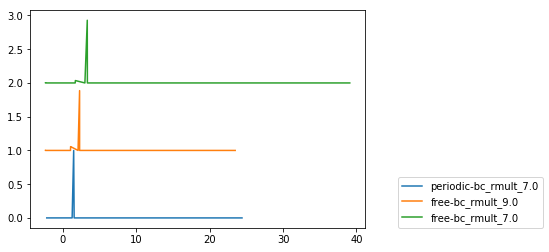

In [178]:
offs = 0.0
for bc,e in excitations.iteritems():
    for r,val in e.iteritems():
        nalpha = val.keys()
        nalpha.sort()
        print nalpha
        emax = [R.engMax(Data[bc][r],numOrb,na) for na in range(1,nalpha[-1]+1)]
        print 'len emax' , len(emax)
        if tr in val[nalpha[-1]].keys():
            wAlpha = val[nalpha[-1]][tr]['weightAlpha']
            print 'len w', len(wAlpha)
            plt.plot(emax,offs+np.array(wAlpha),label=bc+'_rmult_'+str(r))
        offs+=1
plt.legend(loc=(1.1,0.0))

In [ ]:
#####################################################################################################

## Stability of the relevant excitations

To understand why the spectrum changes from rmult 7 to 9 we perform an analysis of the properties of the excitations that are relevant for the costruction of the spectrum e compare the results for the two values of rmult.

Now we start to analyze the transitions more relevant for the specrtum. We plot the oscillator strenght

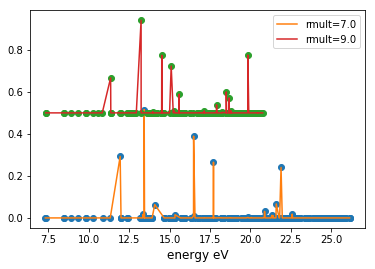

In [48]:
offs = 0.0
for r in rmult:
    allTr, trEnergy = R.allTransitions(excitations[r])
    na = excitations[r].keys()[-1]
    oscStrenght = []
    for tr in allTr:
        oscStrenght.append(excitations[r][na]['transitions'][tr]['oscStrenght'])
    plt.plot(trEnergy,offs+np.array(oscStrenght),'o')
    plt.plot(trEnergy,offs+np.array(oscStrenght),label = 'rmult='+str(r))
    #plt.plot(offs+np.array(oscStrenght),'o')
    #plt.plot(offs+np.array(oscStrenght),label = 'rmult='+str(r))
    offs+=0.5
plt.legend()
plt.xlabel('energy eV', size=12)
plt.show()

Build the dictionary with the most relevant transitions

In [27]:
relTransitions = {}
relEnergy = {}
relOscStrenght = {}
for r in rmult:
    relTransitions[r] = []
    relEnergy[r] = []
    relOscStrenght[r] = []
    na = excitations[r].keys()[-1]
    allTr, trEnergy = R.allTransitions(excitations[r])
    for ind,tr in enumerate(allTr):
        osc = excitations[r][na]['transitions'][tr]['oscStrenght'] 
        if  osc > 0.1:
            relTransitions[r].append(tr)
            relEnergy[r].append(trEnergy[ind])
            relOscStrenght[r].append(osc)
        

In [28]:
for r in rmult:
    print relTransitions[r]
    print relEnergy[r]
    print relOscStrenght[r]

['5to4-0', '3,4to5,6-6+3,4to5,6-5', '2to7-1', '5to22-0', '2to30-0']
[11.94476225779843, 13.431632699878232, 16.492041953851057, 17.72398010006172, 21.907486314446217]
[0.2926858196809133, 0.5155401131505235, 0.3891823859612723, 0.2651982944933355, 0.2402204650804506]
['5to4-0', '2to1-1+2to2-1', '2,5to4,22-1', '3to12-1+4to12-1', '5to71-0']
[11.354487481245043, 13.241617360350151, 14.519996884955464, 15.104261081447103, 19.852670105093267]
[0.16684251889565177, 0.4410122563599942, 0.2741581074909661, 0.22246241572469436, 0.27540134296020063]
